# Détection de faux billets

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.mlab as mlab
import seaborn as sns
import numpy as np
import pandas as pd
import scipy as sp
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sklearn as sk
from scipy.stats import ks_2samp

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn import decomposition, preprocessing
from sklearn.cluster import KMeans

In [3]:
def eta_squared(x,y):
  """Fonction qui calcule l'effet de la taille dans le cadre d'une ANOVA à un facteur
  Entrées : 
  - une variable catégorielle x,
  - une variable quantitative y.

  Sortie :
  - résultat de l'eta-carré
  """
  moyenne_y = y.mean()
  classes = []
  for classe in x.unique():
    yi_classe = y[x==classe]
    classes.append({'ni': len(yi_classe),
                    'moyenne_classe': yi_classe.mean()})
  SCT = sum([(yj-moyenne_y)**2 for yj in y])
  SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
  return SCE/SCT

def distrib_normalize(i):
  """Fonction qui trace la distribution d'une variable et qui calcule la symétrie, 
  le coefficient d'applatissement et le respect à une loi statistique : ici la loi normale
  Entrée : 
  - Colonne d'une variable

  Sortie : 
  - Graphique de distribution
  - Résultat de la symétrie
  - Résultat du coefficient d'applatissement
  - Résultat à l'adéquation à la loi normale
  """
  print(i.capitalize())
  _ = sns.displot(df[i])
  _ = plt.axvline(x=df[i].mean(), label='Moyenne', linestyle='-', color='r', linewidth=2)
  _ = plt.axvline(x=df[i].median(), label='Médiane', linestyle='--', color='b', linewidth=2)
  _ = plt.show()
  print('Skewness: ', str(sp.stats.skew(df[i])))
  print('Kurtosis: ', str(sp.stats.kurtosis(df[i])))
  print(str(ks_2samp(df[i],list(np.random.normal(np.mean(df[i]), np.std(df[i]), 1000)))))

########################
##FONCTIONS DE DESSINS##
########################

def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
  """
  Fonction qui trace le cercle de corrélation de l'ACP

  Entrées : 
  - Coordonnées des points de l'ACP
  - Nombre de composantes
  - Fonction de l'ACP dans sklearn
  - Composantes que l'on souhaite représenter

  Sortie : 
  - Cercle de corrélation  
  """
  for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
      if d2 < n_comp:

          # initialisation de la figure
          fig, ax = plt.subplots(figsize=(10,10))

          # détermination des limites du graphique
          if lims is not None :
              xmin, xmax, ymin, ymax = lims
          elif pcs.shape[1] < 30 :
              xmin, xmax, ymin, ymax = -1, 1, -1, 1
          else :
              xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

          # affichage des flèches
          # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
          if pcs.shape[1] < 30 :
              plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                pcs[d1,:], pcs[d2,:], 
                angles='xy', scale_units='xy', scale=1, color="grey")
              # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
          else:
              lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
              ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
          # affichage des noms des variables  
          if labels is not None:  
              for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                  if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                    plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
          # affichage du cercle
          an = np.linspace(0, 2 * np.pi, 100)  # Add a unit circle for scale
          plt.plot(np.cos(an), np.sin(an))
          plt.axis('equal')

          # définition des limites du graphique
          plt.xlim(xmin, xmax)
          plt.ylim(ymin, ymax)
        
          # affichage des lignes horizontales et verticales
          plt.plot([-1, 1], [0, 0], color='grey', ls='--')
          plt.plot([0, 0], [-1, 1], color='grey', ls='--')

          # nom des axes, avec le pourcentage d'inertie expliqué
          plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
          plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

          plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
          plt.show(block=False)
        
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
  """Fonction qui trace la représentation des individus sur les plans factoriels

  Entrées :
  - Individus projetés
  - Nombre de composante
  - Fonction de l'ACP issue de Sklearn
  - Composantes que l'on souhaite représenter
  - Variables illustratives

  Sortie : 
  - Projection des individus sur les composantes sélectionnées
  """
  for d1,d2 in axis_ranks:
    if d2 < n_comp:
      # initialisation de la figure       
      fig = plt.figure(figsize=(7,6))
        
      # affichage des points
      if illustrative_var is None:
        plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
      else:
        illustrative_var = np.array(illustrative_var)
      for value in np.unique(illustrative_var):
        selected = np.where(illustrative_var == value)
        plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
      plt.legend()

      # affichage des labels des points
      if labels is not None:
        for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
          plt.text(x, y, labels[i],
          fontsize='14', ha='center',va='center') 
                
      # détermination des limites du graphique
      boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
      plt.xlim([-boundary,boundary])
      plt.ylim([-boundary,boundary])
        
      # affichage des lignes horizontales et verticales
      plt.plot([-100, 100], [0, 0], color='grey', ls='--')
      plt.plot([0, 0], [-100, 100], color='grey', ls='--')

      # nom des axes, avec le pourcentage d'inertie expliqué
      plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
      plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

      plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
      plt.show(block=False)

In [4]:
sns.set( 
    style='whitegrid',
    context='notebook',
    palette='Paired',
    rc={'figure.figsize':(8,5)})

# Mission 0 : Description des données
Afin d'introduire votre analyse, effectuez une brève description des données (analyses univariées et bivariées).

In [5]:
df = pd.read_csv('notes.csv')
df

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.67,103.74,103.70,4.01,2.87,113.29
2,True,171.83,103.76,103.76,4.40,2.88,113.84
3,True,171.80,103.78,103.65,3.73,3.12,113.63
4,True,172.05,103.70,103.75,5.04,2.27,113.55
...,...,...,...,...,...,...,...
165,False,172.11,104.23,104.45,5.24,3.58,111.78
166,False,173.01,104.59,104.31,5.04,3.05,110.91
167,False,172.47,104.27,104.10,4.88,3.33,110.68
168,False,171.82,103.97,103.88,4.73,3.55,111.87


In [6]:
df['is_genuine'].unique()

array([ True, False])

In [7]:
df.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000
mean,171.940588,104.066353,103.928118,4.612118,3.170412,112.570412
std,0.305768,0.298185,0.330980,0.702103,0.236361,0.924448
min,171.040000,103.230000,103.140000,3.540000,2.270000,109.970000
25%,171.730000,103.842500,103.690000,4.050000,3.012500,111.855000
50%,171.945000,104.055000,103.950000,4.450000,3.170000,112.845000
75%,172.137500,104.287500,104.170000,5.127500,3.330000,113.287500
max,173.010000,104.860000,104.950000,6.280000,3.680000,113.980000


In [8]:
df.isnull().sum()

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

In [9]:
df.duplicated().sum()

0

Il n'y a pas de valeurs manquantes ou dupliquées

In [10]:
description = df.groupby('is_genuine').describe().T
print(description)

is_genuine               False       True 
diagonal     count   70.000000  100.000000
             mean   171.889857  171.976100
             std      0.297426    0.307981
             min    171.380000  171.040000
             25%    171.682500  171.790000
             50%    171.875000  172.005000
             75%    172.047500  172.162500
             max    173.010000  172.750000
height_left  count   70.000000  100.000000
             mean   104.230429  103.951500
             std      0.213130    0.296251
             min    103.780000  103.230000
             25%    104.082500  103.740000
             50%    104.215000  103.915000
             75%    104.377500  104.145000
             max    104.720000  104.860000
height_right count   70.000000  100.000000
             mean   104.145571  103.775900
             std      0.253152    0.292406
             min    103.440000  103.140000
             25%    103.982500  103.557500
             50%    104.170000  103.760000
           

Il n'y a pas d'outliers.

In [11]:
df['is_genuine'].value_counts()

True     100
False     70
Name: is_genuine, dtype: int64

### Vrai billet

Il y a 70 faux billets et 100 vrais billets. 

Un vrai billet a :
- diagonale : entre 171.9761 et 172.75 mm
- hauteur à gauche : entre 103.23 et 104.86 mm
- hauteur à droite : entre 103.14 et 104.95 mm
- marge en bas : entre 3.54 et 5.04 mm
- marge en haut : entre 2.27 et 3.53
- longueur : entre 111.76 et 113.98 mm

### Faux billet

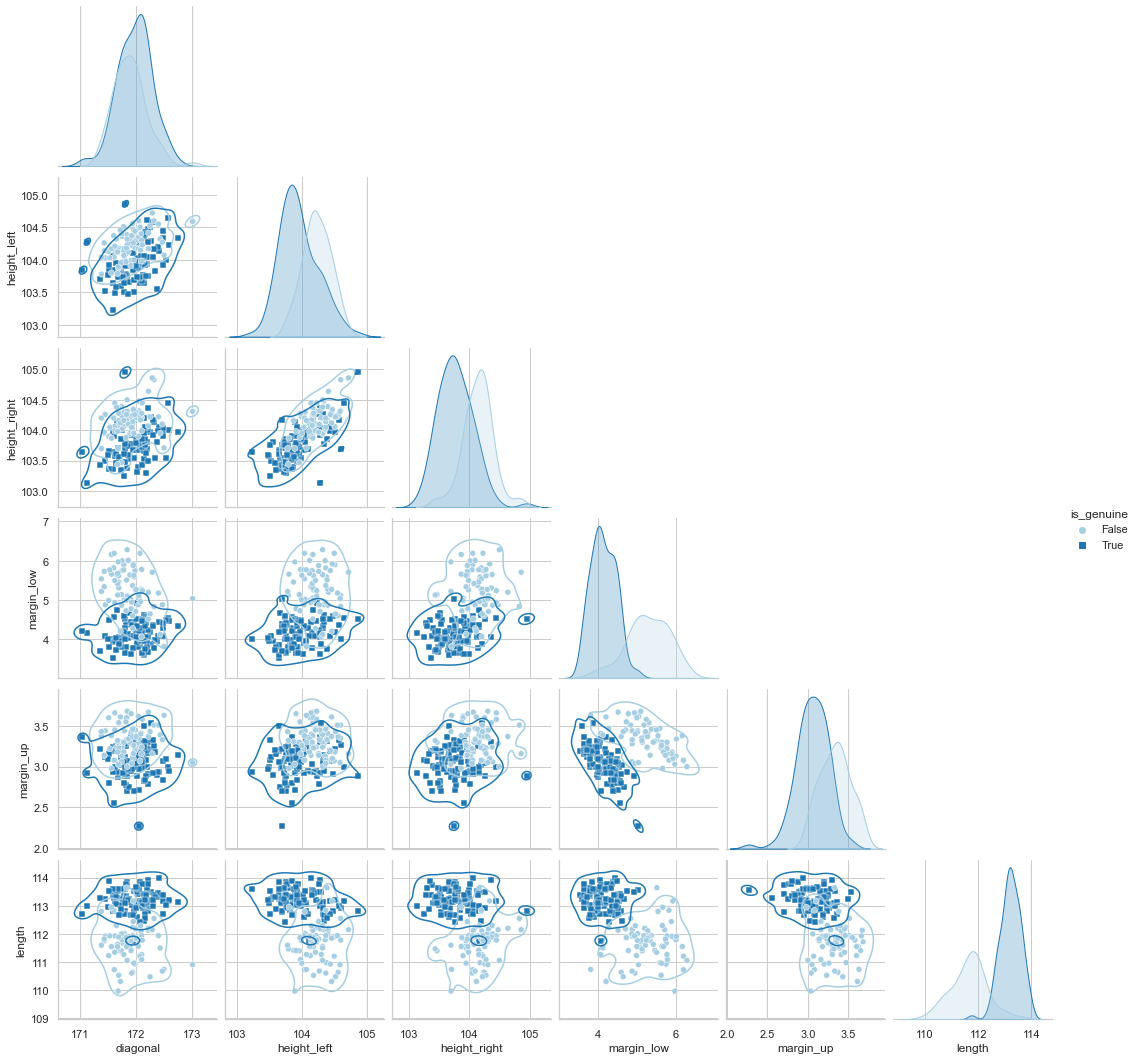

In [12]:
g = sns.pairplot(df, hue='is_genuine', markers=['o','s'], corner=True)
g.map_lower(sns.kdeplot, levels=2, color='.2')
plt.show()

Les faux billets se distinguent par une plus forte marge basse, mais une plus faible longueur.

Diagonal


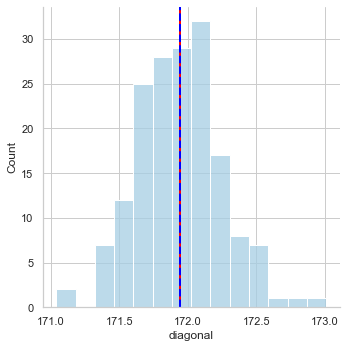

Skewness:  0.19443137121477527
Kurtosis:  0.5346375075188288
KstestResult(statistic=0.06476470588235295, pvalue=0.5513960074657216)
Height_left


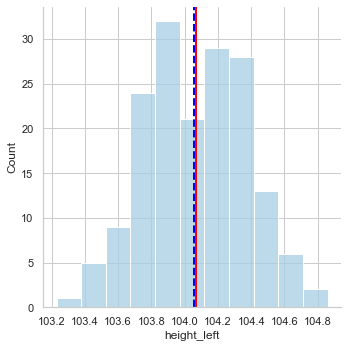

Skewness:  0.02839494808973424
Kurtosis:  -0.4833327619035872
KstestResult(statistic=0.06464705882352942, pvalue=0.5537221722409287)
Height_right


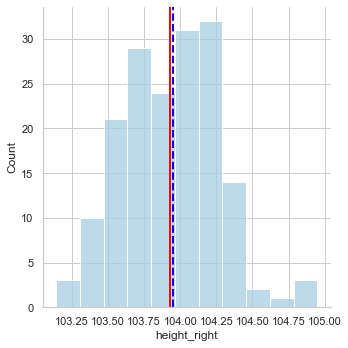

Skewness:  0.16739211723354264
Kurtosis:  -0.03982952213509616
KstestResult(statistic=0.04523529411764706, pvalue=0.9125726364531149)
Margin_low


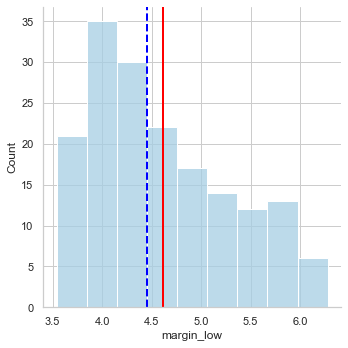

Skewness:  0.5796855414374862
Kurtosis:  -0.75717722821391
KstestResult(statistic=0.10470588235294118, pvalue=0.07635896584882651)
Margin_up


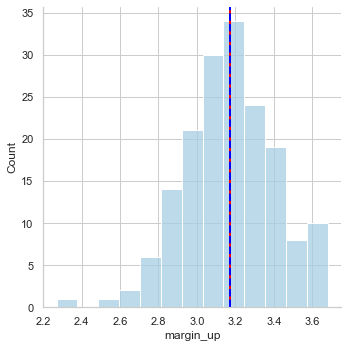

Skewness:  -0.2025055216127945
Kurtosis:  0.49813176957106853
KstestResult(statistic=0.04311764705882353, pvalue=0.9377034391835253)
Length


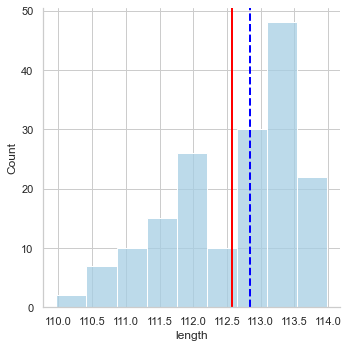

Skewness:  -0.6506712141894133
Kurtosis:  -0.5531969324412676
KstestResult(statistic=0.12094117647058823, pvalue=0.025924310310957654)


In [13]:
cols = df[['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']]

for i in cols:
    distrib_normalize(i)

Margin_low et length ne suivent pas la loi normale.

In [14]:
x = df['margin_up']
y = df['margin_low']

print('rho de pearson :', sp.stats.pearsonr(x, y)[0])
print('indice de covariation :', np.cov(x, y, ddof=0)[1,0])

Y = df['margin_low']
X = df[['margin_up']]
X = X.copy()
X['intercept'] = 1.
result = sm.OLS(Y, X).fit()
a,b = result.params['margin_up'],result.params['intercept']
print('r-squared : ', (sp.stats.pearsonr(x,y)[0])**2)

rho de pearson : 0.17111283050073067
indice de covariation : 0.028229128027681655
r-squared :  0.029279600761971784


C:\Users\maxim\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


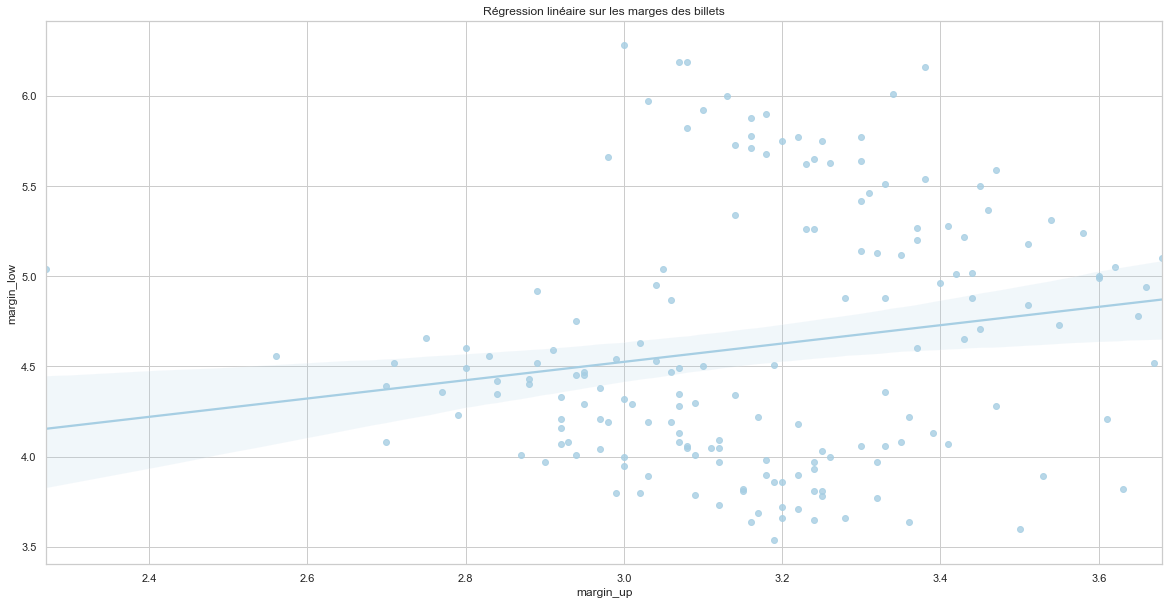

In [15]:
plt.figure(figsize=(20,10))
sns.regplot(x, y, fit_reg=True)
plt.title('Régression linéaire sur les marges des billets')
plt.savefig('Régression linéaire sur les marges des billets')
plt.show()

In [16]:
x = df['height_right']
y = df['height_left']

print('rho de pearson :', sp.stats.pearsonr(x, y)[0])
print('indice de covariation :', np.cov(x, y, ddof=0)[1,0])

Y = df['height_left']
X = df[['height_right']]
X = X.copy()
X['intercept'] = 1.
result = sm.OLS(Y, X).fit()
a,b = result.params['height_right'],result.params['intercept']
print('r-squared : ', (sp.stats.pearsonr(x,y)[0])**2)

rho de pearson : 0.7343902682297871
indice de covariation : 0.07205313494809684
r-squared :  0.5393290660706187


C:\Users\maxim\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


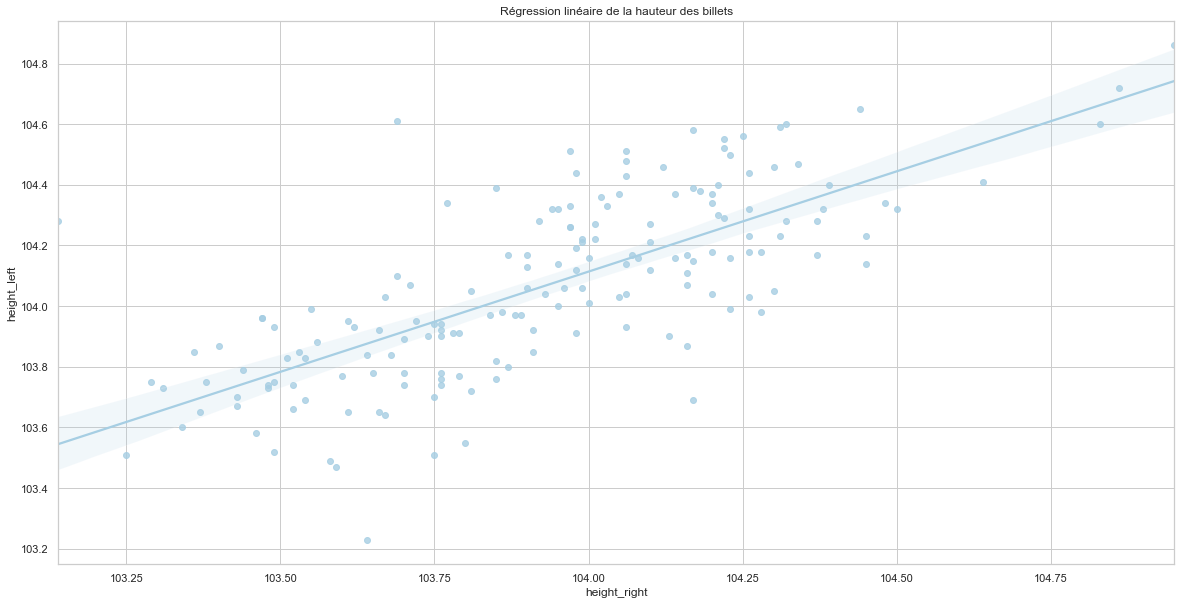

In [17]:
plt.figure(figsize=(20,10))
sns.regplot(x, y, fit_reg=True)
plt.title('Régression linéaire de la hauteur des billets')
plt.savefig('Régression linéaire de la hauteur des billets')
plt.show()

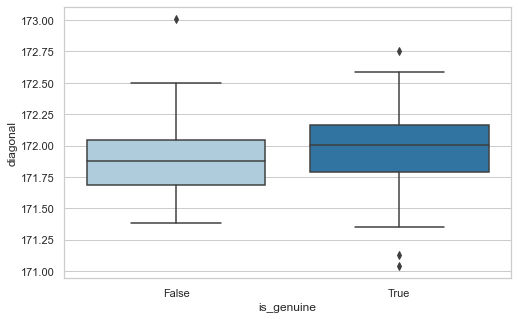

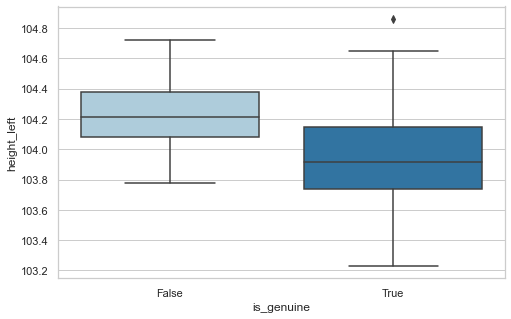

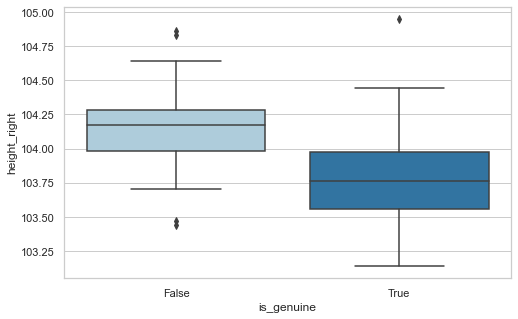

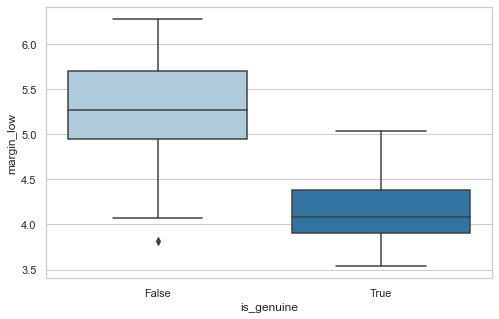

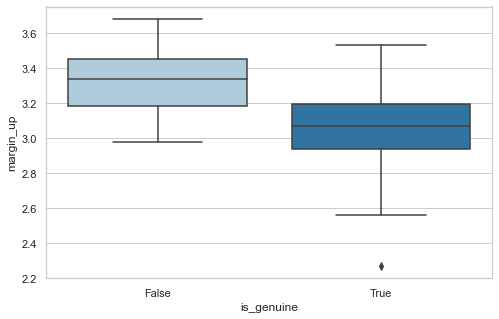

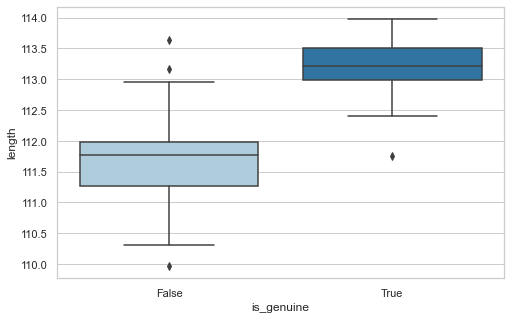

In [18]:
for i in cols: 
    _ = sns.boxplot(x='is_genuine', y=i, data=df)
    _ = plt.show()

In [19]:
for i in cols:
    print(i.capitalize())
    X = df['is_genuine'] # qualitative
    Y = df[i] # quantitative
    print('eta-squared :', eta_squared(X,Y))

Diagonal
eta-squared : 0.019383108567093802
Height_left
eta-squared : 0.21319458315018705
Height_right
eta-squared : 0.30394154672012125
Margin_low
eta-squared : 0.640177214288775
Margin_up
eta-squared : 0.3396567096032002
Length
eta-squared : 0.6818507654957807


Si eta carré (R²), la taille de l'effet, égale :
- environ 0.01 : petit effet
- environ 0.06 : moyen effet
- sup 0.14 : grand effet

In [20]:
cols_0 = df[['margin_low', 'length']]
cols_1 = df[['diagonal', 'height_right','margin_up']]

for i in cols:
    true = df.loc[df['is_genuine'] == True][i]
    false = df.loc[df['is_genuine'] == False][i]
    print(i.capitalize())
    if i in cols_0:
        print('Test de Mann-Whitney : ', sp.stats.mannwhitneyu(true, false))
    elif i in cols_1:
        print('Test de Bartlett :', sp.stats.bartlett(true,false))
        print('Test de Student :', sp.stats.ttest_ind(true,false, equal_var=True))
    else:
        print('Test de Bartlett :', sp.stats.bartlett(true,false))
        print('Test de Welsch :', sp.stats.ttest_ind(true,false, equal_var=False))

Diagonal
Test de Bartlett : BartlettResult(statistic=0.09785668979597505, pvalue=0.7544170098956573)
Test de Student : Ttest_indResult(statistic=1.8222865515506024, pvalue=0.07018967008887296)
Height_left
Test de Bartlett : BartlettResult(statistic=8.294302164373534, pvalue=0.003976965959594022)
Test de Welsch : Ttest_indResult(statistic=-7.138967397007879, pvalue=2.7083988500085442e-11)
Height_right
Test de Bartlett : BartlettResult(statistic=1.6456014709345594, pvalue=0.19955865324739466)
Test de Student : Ttest_indResult(statistic=-8.564989194564754, pvalue=6.665246409290165e-15)
Margin_low
Test de Mann-Whitney :  MannwhitneyuResult(statistic=306.0, pvalue=2.44739545685913e-24)
Margin_up
Test de Bartlett : BartlettResult(statistic=0.34879710746030196, pvalue=0.554794849415443)
Test de Student : Ttest_indResult(statistic=-9.295866009945723, pvalue=7.567386063614238e-17)
Length
Test de Mann-Whitney :  MannwhitneyuResult(statistic=226.0, pvalue=1.7876766232996412e-25)


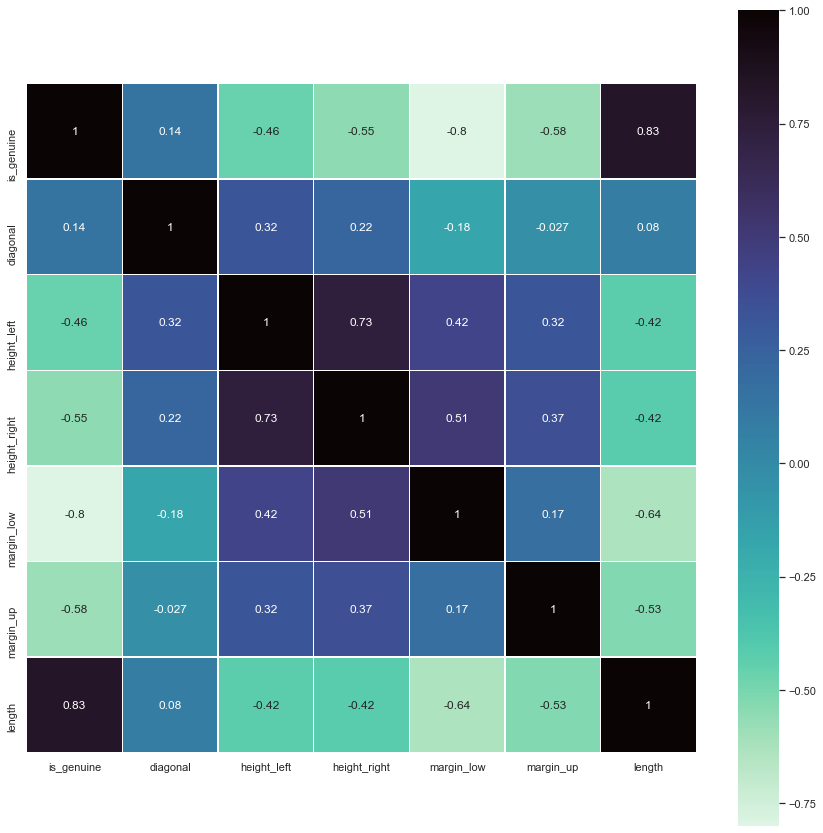

In [21]:
corrMatrix = df.corr()
plt.figure(figsize=(15,15))
_ = sns.heatmap(corrMatrix, square=True, annot=True, linewidths=.5, cmap='mako_r')
_ = plt.savefig('Matrice des corrélations')
_ = plt.show()

Corrélation positive la plus forte : height_right et height_left, is_genuine et length
<br>Corrélation quasi nulle : margin_up et diagonal
<br>Corrélations négatives les plus fortes : length et margin_low . length et margin_up

# Mission 1 : ACP

Vous réaliserez une analyse en composantes principales de l'échantillon, en suivant toutes ces étapes :
<br>•	analyse de l'éboulis des valeurs propres ;
<br>•	représentation des variables par le cercle des corrélations ;
<br>•	représentation des individus par les plans factoriels ;
<br>•	analyser de la qualité de représentation et la contribution des individus.
<br>Pour chacune de ces étapes, commentez les résultats obtenus. La variable donnant la nature Vrai/Faux du billet sera utilisée comme variable illustrative.


## Standardisation

Les variables sont centrées autour de 0, tout en gardant leur distribution, pour pouvoir réaliser l'ACP.



In [22]:
data_acp = df.drop(columns='is_genuine')

print(data_acp.shape)
n = data_acp.shape[0]
p = data_acp.shape[1]

(170, 6)


In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

sc = StandardScaler()
Z = sc.fit_transform(data_acp)


print(Z)

[[-0.42834385  2.6694537   3.09656321 -0.13159013 -1.18987367  0.28163308]
 [-0.88755932 -1.09769709 -0.69125444 -0.86012554 -1.27473985  0.78069736]
 [-0.36274164 -1.03042654 -0.50943919 -0.30301023 -1.23230676  1.37740465]
 ...
 [ 1.73652911  0.68497248  0.52084721  0.38267015  0.67718214 -2.05094997]
 [-0.39554274 -0.32408577 -0.1458087   0.16839504  1.61071005 -0.75989238]
 [ 0.06367273 -0.22317994  0.06630909  1.45404575  0.38015054 -1.74717171]]


In [24]:
acp = PCA()
coord = acp.fit_transform(Z)
print(acp.n_components_)

6


In [25]:
#variance expliquée
print(acp.explained_variance_)

[2.86372065 1.32522178 0.85912514 0.51460481 0.27840703 0.19442354]


In [26]:
#valeur corrigée
eigval = (n-1)/n*acp.explained_variance_
print(eigval)

[2.84687523 1.31742636 0.85407146 0.51157773 0.27676935 0.19327987]


In [27]:
# proportion de valeurs expliquées
ratio = acp.explained_variance_ratio_ * 100
print(acp.explained_variance_ratio_)

[0.47447921 0.21957106 0.14234524 0.08526295 0.04612822 0.03221331]


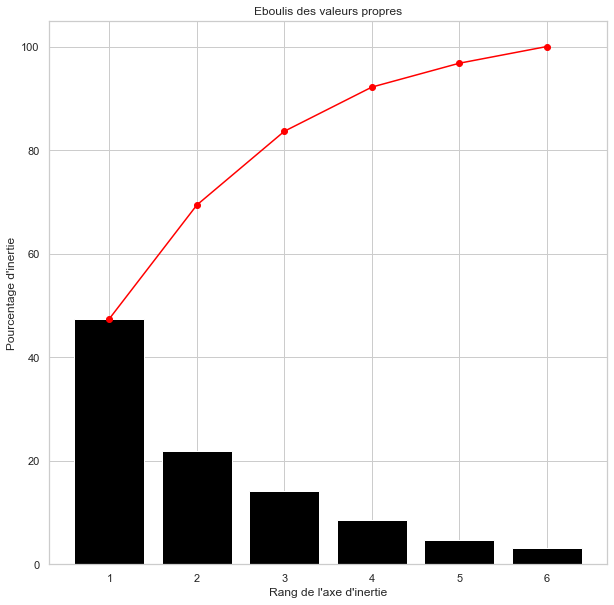

In [28]:
fig, ax = plt.subplots(figsize=(10,10))
scree = acp.explained_variance_ratio_*100
plt.bar(np.arange(len(scree))+1, scree, color='black')
plt.plot(np.arange(len(scree))+1, scree.cumsum(),marker='o', color='r')
plt.xlabel("Rang de l'axe d'inertie")
plt.ylabel("Pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

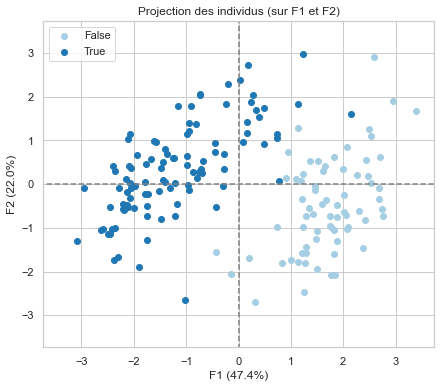

In [29]:
display_factorial_planes(coord, p, acp, [(0,1)], illustrative_var=df['is_genuine'])

In [30]:
n_components = 2 
for i in range(0, n_components): 
    df['PC' + str(i + 1)] = Z[:, i]
df

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,PC1,PC2
0,True,171.81,104.86,104.95,4.52,2.89,112.83,-0.428344,2.669454
1,True,171.67,103.74,103.70,4.01,2.87,113.29,-0.887559,-1.097697
2,True,171.83,103.76,103.76,4.40,2.88,113.84,-0.362742,-1.030427
3,True,171.80,103.78,103.65,3.73,3.12,113.63,-0.461145,-0.963156
4,True,172.05,103.70,103.75,5.04,2.27,113.55,0.358883,-1.232238
...,...,...,...,...,...,...,...,...,...
165,False,172.11,104.23,104.45,5.24,3.58,111.78,0.555689,0.550431
166,False,173.01,104.59,104.31,5.04,3.05,110.91,3.507789,1.761301
167,False,172.47,104.27,104.10,4.88,3.33,110.68,1.736529,0.684972
168,False,171.82,103.97,103.88,4.73,3.55,111.87,-0.395543,-0.324086


In [31]:
# contribution des individus dans l'inertie totale
di = np.sum(Z**2,axis=1)
print(pd.DataFrame({'ID':data_acp.index,'d_i':di}))

      ID        d_i
0      0  18.410598
1      1   5.444799
2      2   4.960527
3      3   4.805719
4      4  18.039567
..   ...        ...
165  165   7.673233
166  166  20.625650
167  167   8.567410
168  168   3.482926
169  169   5.369633

[170 rows x 2 columns]


In [32]:
# qualité de représentation des individus - COS2
cos2 = coord**2

for j in range(p):
  cos2[:,j] = cos2[:,j]/di

qualite = pd.DataFrame({'id':data_acp.index,'COS2_F1':cos2[:,0],'COS2_F2':cos2[:,1]})

print(qualite)

      id   COS2_F1   COS2_F2
0      0  0.251929  0.139000
1      1  0.818002  0.050822
2      2  0.784862  0.000466
3      3  0.882856  0.001652
4      4  0.320145  0.009417
..   ...       ...       ...
165  165  0.800651  0.004703
166  166  0.324059  0.411824
167  167  0.498809  0.083461
168  168  0.156908  0.271800
169  169  0.421817  0.217111

[170 rows x 3 columns]


In [33]:
print(qualite.sort_values('COS2_F1', ascending=False).head(10))


      id   COS2_F1   COS2_F2
143  143  0.973456  0.007584
46    46  0.962296  0.003343
101  101  0.908310  0.037607
94    94  0.906118  0.045729
123  123  0.904783  0.047258
90    90  0.898122  0.061454
111  111  0.896997  0.028916
132  132  0.885530  0.012440
3      3  0.882856  0.001652
105  105  0.882824  0.007530


In [34]:
print(qualite.sort_values('COS2_F2', ascending=False).head(10))


      id   COS2_F1   COS2_F2
21    21  0.000164  0.935643
156  156  0.013014  0.919036
33    33  0.017244  0.911419
34    34  0.004225  0.890595
23    23  0.006820  0.850794
36    36  0.110271  0.833974
53    53  0.013805  0.775037
5      5  0.132447  0.771985
26    26  0.089474  0.722621
22    22  0.026330  0.692767


In [35]:
#vérifions la théorie - somme en ligne des cos2 = 1
print(np.sum(cos2,axis=1))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]


In [36]:
# contribution aux axes
ctr = coord**2
for j in range(p):
  ctr[:,j] = ctr[:,j]/(n*eigval[j]) # eigval = c. 40 (variance expliquée et corrigé)

contribution = pd.DataFrame({'id':data_acp.index,'CTR_F1':ctr[:,0],'CTR_F2':ctr[:,1]})
print(contribution)

      id    CTR_F1    CTR_F2
0      0  0.009584  0.011426
1      1  0.009203  0.001236
2      2  0.008045  0.000010
3      3  0.008767  0.000035
4      4  0.011933  0.000759
..   ...       ...       ...
165  165  0.012694  0.000161
166  166  0.013811  0.037927
167  167  0.008830  0.003193
168  168  0.001129  0.004227
169  169  0.004680  0.005205

[170 rows x 3 columns]


In [37]:
print(contribution.sort_values('CTR_F1', ascending=False).head(10))


      id    CTR_F1    CTR_F2
122  122  0.023758  0.012372
49    49  0.019620  0.007487
29    29  0.018089  0.000038
112  112  0.017950  0.016259
158  158  0.015836  0.002423
101  101  0.015483  0.001385
147  147  0.015085  0.001778
121  121  0.014871  0.000033
146  146  0.014783  0.000500
7      7  0.014226  0.004831


In [38]:
print(contribution.sort_values('CTR_F2', ascending=False).head(10))


      id    CTR_F1    CTR_F2
5      5  0.003155  0.039736
166  166  0.013811  0.037927
34    34  0.000073  0.033302
156  156  0.000211  0.032264
70    70  0.002197  0.031516
151  151  0.003251  0.026922
21    21  0.000002  0.025151
23    23  0.000088  0.023682
131  131  0.006470  0.019298
153  153  0.006999  0.019276


In [39]:
#vérifions la théorie
print(np.sum(ctr,axis=0))

[1. 1. 1. 1. 1. 1.]


In [40]:
#le champs components_ de l'objet ACP
print(acp.components_)

[[ 0.07327499  0.47550205  0.4918214   0.43102671  0.35253984 -0.46537288]
 [ 0.77963908  0.33925019  0.23554253 -0.32053699 -0.14111974  0.31453645]
 [-0.08889419  0.12276016  0.15383022  0.5128076  -0.82114881  0.12691346]
 [-0.55973158  0.2780463   0.45893794 -0.22652773  0.13533955  0.57370304]
 [-0.22509444  0.71592059 -0.48699285 -0.31190784 -0.1939426  -0.25441684]
 [ 0.12216606  0.23213146 -0.4808135   0.54763041  0.35437971  0.52395111]]


In [41]:
#racine carrée des valeurs propres
sqrt_eigval = np.sqrt(eigval)

#corrélation des variables avec les axes
corvar = np.zeros((p,p))
for k in range(p):
  corvar[:,k] = acp.components_[k,:] * sqrt_eigval[k]

#afficher la matrice des corrélations variables x facteurs    
print(corvar)

[[ 0.1236346   0.89486346 -0.08215244 -0.40034612 -0.11841965  0.05370861]
 [ 0.80229967  0.38938864  0.11345001  0.19887167  0.37663775  0.10205336]
 [ 0.8298348   0.27035382  0.14216371  0.32825381 -0.25620145 -0.21138296]
 [ 0.72725782 -0.36790977  0.4739162  -0.16202319 -0.1640912   0.24075808]
 [ 0.59482939 -0.1619761  -0.75887278  0.09680115 -0.10203101  0.15579811]
 [-0.78520903  0.36102241  0.11728832  0.41033916 -0.13384583  0.23034781]]


In [42]:
#on affiche pour les deux premiers axes
print(pd.DataFrame({'id':data_acp.columns,'COR_1':corvar[:,0],'COR_2':corvar[:,1]}))

             id     COR_1     COR_2
0      diagonal  0.123635  0.894863
1   height_left  0.802300  0.389389
2  height_right  0.829835  0.270354
3    margin_low  0.727258 -0.367910
4     margin_up  0.594829 -0.161976
5        length -0.785209  0.361022


In [43]:
data_acp.columns

Index(['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up',
       'length'],
      dtype='object')

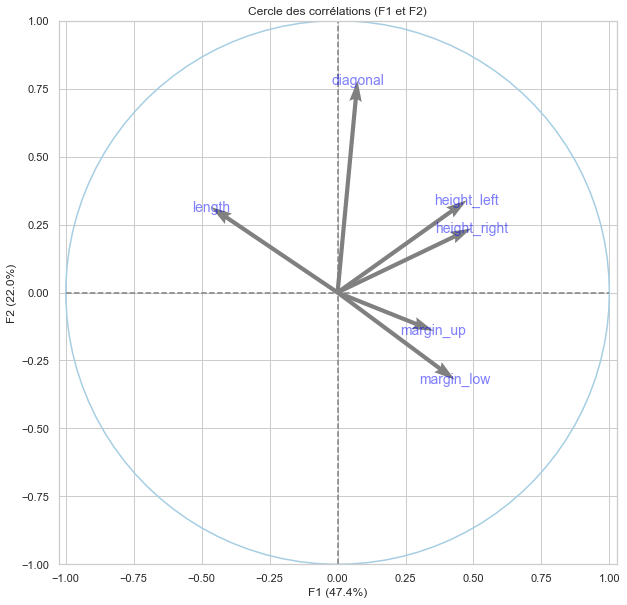

In [44]:
pcs = acp.components_
features = data_acp.columns
display_circles(pcs, p, acp, [(0,1)], labels = np.array(features))

PC1 correspond aux informations de marges et hauteurs.<br>
PC2 correspond aux informations de longueur.

<br>Les deux Height et les deux Margin sont corrélées positivement.

In [45]:
#cosinus carré des variables
cos2var = corvar**2
print(pd.DataFrame({'id':data_acp.columns,'COS2_1':cos2var[:,0],'COS2_2':cos2var[:,1]}))

             id    COS2_1    COS2_2
0      diagonal  0.015286  0.800781
1   height_left  0.643685  0.151624
2  height_right  0.688626  0.073091
3    margin_low  0.528904  0.135358
4     margin_up  0.353822  0.026236
5        length  0.616553  0.130337


In [46]:
#contributions
ctrvar = cos2var
for k in range(p):
  ctrvar[:,k] = ctrvar[:,k]/eigval[k]

#on n'affiche que pour les deux premiers axes
print(pd.DataFrame({'id':data_acp.columns,'CTR_1':ctrvar[:,0],'CTR_2':ctrvar[:,1]}))

             id     CTR_1     CTR_2
0      diagonal  0.005369  0.607837
1   height_left  0.226102  0.115091
2  height_right  0.241888  0.055480
3    margin_low  0.185784  0.102744
4     margin_up  0.124284  0.019915
5        length  0.216572  0.098933


# Mission 2 : Classification

## Dendrogramme

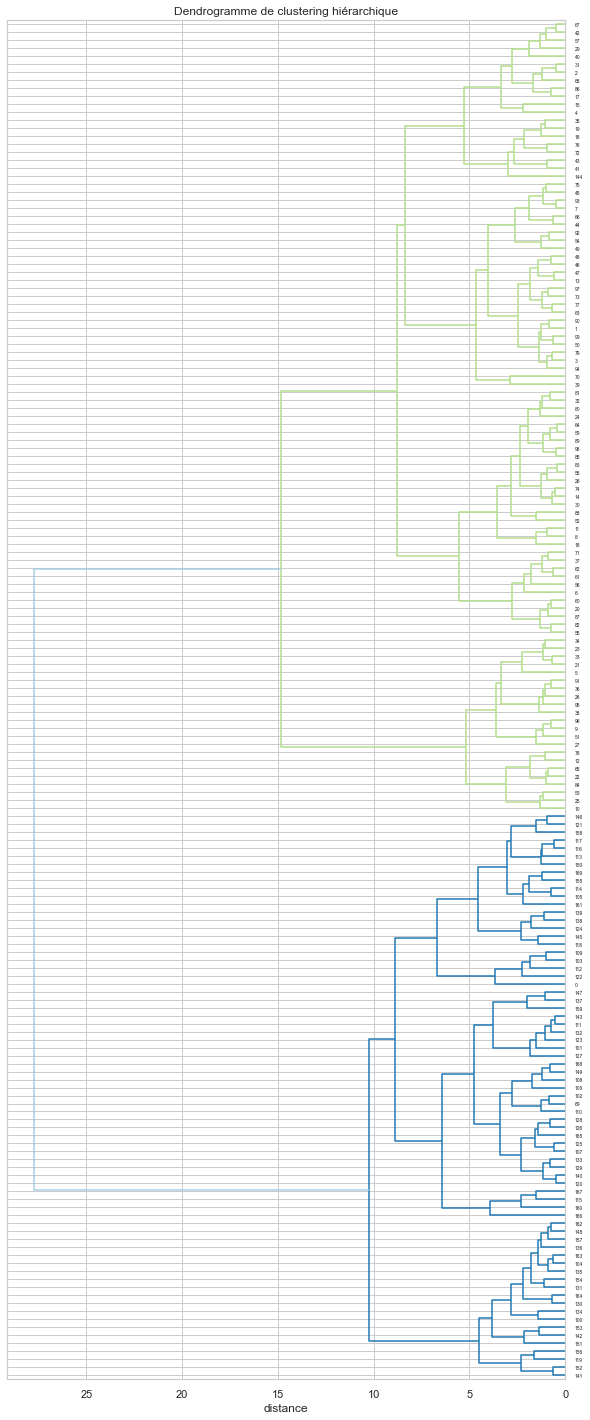

In [47]:
# préparation des données pour le clustering
X = data_acp.values
names = data_acp.index

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Clustering hiérarchique
Z = linkage(X_scaled, 'ward')

# Affichage du dendrogramme
plt.figure(figsize=(10,25))
plt.title('Dendrogramme de clustering hiérarchique')
plt.xlabel('distance')
dendrogram(
    Z,
    labels = names,
    orientation = "left")
plt.show()

In [48]:
# Découpage en deux clusters
clusters = fcluster(Z, 2, criterion='maxclust')
data_cluster = pd.DataFrame({'cluster' : clusters})
df = df.drop(['PC1','PC2'], axis=1)
data = df.join(data_cluster)
illustrative_var = data['cluster']

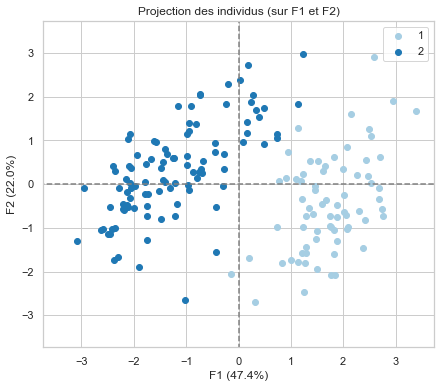

In [49]:
display_factorial_planes(coord, p, acp, [(0,1)], illustrative_var=illustrative_var)


In [50]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
pd.options.display.max_rows

<ipython-input-50-137de55fcafe>:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [51]:
description = data.groupby('cluster').describe().transpose()
print(description)

cluster                      1           2
diagonal     count  71.000000   99.000000 
             mean   171.894085  171.973939
             std    0.292836    0.311909  
             min    171.380000  171.040000
             25%    171.690000  171.780000
             50%    171.890000  172.010000
             75%    172.045000  172.165000
             max    173.010000  172.750000
height_left  count  71.000000   99.000000 
             mean   104.243662  103.939192
             std    0.218679    0.282953  
             min    103.780000  103.230000
             25%    104.115000  103.740000
             50%    104.220000  103.910000
             75%    104.385000  104.120000
             max    104.860000  104.650000
height_right count  71.000000   99.000000 
             mean   104.160986  103.761111
             std    0.266631    0.265841  
             min    103.440000  103.140000
             25%    103.990000  103.555000
             50%    104.170000  103.760000
           

In [52]:
cols_0 = data[['margin_low', 'length']]
cols_1 = data[['diagonal', 'height_right', 'margin_up']]

for i in cols:
    genuine = data.loc[data['is_genuine'] == True][i]
    cluster = data.loc[data['cluster'] == 1][i]
    print(i.capitalize())
    if i in cols_0:
        print('Test de Mann-Whitney : ', sp.stats.mannwhitneyu(genuine, cluster))
    elif i in cols_1:
        print('Test de Bartlett :', sp.stats.bartlett(genuine,cluster))
        print('Test de Student :', sp.stats.ttest_ind(genuine,cluster, equal_var=True))
    else:
        print('Test de Bartlett :', sp.stats.bartlett(genuine,cluster))
        print('Test de Welsch :', sp.stats.ttest_ind(genuine,cluster, equal_var=False))

Diagonal
Test de Bartlett : BartlettResult(statistic=0.20597584767762156, pvalue=0.6499399452134673)
Test de Student : Ttest_indResult(statistic=1.7510857077916284, pvalue=0.08174546372615159)
Height_left
Test de Bartlett : BartlettResult(statistic=7.157870949376627, pvalue=0.00746357345742929)
Test de Welsch : Ttest_indResult(statistic=-7.418111048899185, pvalue=5.531370725404157e-12)
Height_right
Test de Bartlett : BartlettResult(statistic=0.6858875780787472, pvalue=0.4075667001141948)
Test de Student : Ttest_indResult(statistic=-8.798639174469887, pvalue=1.562392586974314e-15)
Margin_low
Test de Mann-Whitney :  MannwhitneyuResult(statistic=369.0, pvalue=1.0259846057333552e-23)
Margin_up
Test de Bartlett : BartlettResult(statistic=0.27367102662870385, pvalue=0.600879779682454)
Test de Student : Ttest_indResult(statistic=-9.273664200826179, pvalue=8.359423529712947e-17)
Length
Test de Mann-Whitney :  MannwhitneyuResult(statistic=220.5, pvalue=8.505073437751944e-26)


In [53]:
cols_0 = data[['margin_low', 'length']]
cols_1 = data[['diagonal', 'height_right', 'margin_up']]

for i in cols:
    genuine = data.loc[data['is_genuine'] == False][i]
    cluster = data.loc[data['cluster'] == 2][i]
    print(i.capitalize())
    if i in cols_0:
        print('Test de Mann-Whitney : ', sp.stats.mannwhitneyu(genuine, cluster))
    elif i in cols_1:
        print('Test de Bartlett :', sp.stats.bartlett(genuine,cluster))
        print('Test de Student :', sp.stats.ttest_ind(genuine,cluster, equal_var=True))
    else:
        print('Test de Bartlett :', sp.stats.bartlett(genuine,cluster))
        print('Test de Welsch :', sp.stats.ttest_ind(genuine,cluster, equal_var=False))

Diagonal
Test de Bartlett : BartlettResult(statistic=0.18087559833827596, pvalue=0.6706218425575824)
Test de Student : Ttest_indResult(statistic=-1.7595206277000377, pvalue=0.08032025349319885)
Height_left
Test de Bartlett : BartlettResult(statistic=6.179889994029566, pvalue=0.01292103098077704)
Test de Welsch : Ttest_indResult(statistic=7.628195184209143, pvalue=1.7466995178898618e-12)
Height_right
Test de Bartlett : BartlettResult(statistic=0.1913404797385084, pvalue=0.6618032818783942)
Test de Student : Ttest_indResult(statistic=9.444500713054603, pvalue=3.1262385711790714e-17)
Margin_low
Test de Mann-Whitney :  MannwhitneyuResult(statistic=349.0, pvalue=1.343938528386236e-23)
Margin_up
Test de Bartlett : BartlettResult(statistic=0.2577207307809787, pvalue=0.6116903851013222)
Test de Student : Ttest_indResult(statistic=9.399815165763334, pvalue=4.1277193797224106e-17)
Length
Test de Mann-Whitney :  MannwhitneyuResult(statistic=189.0, pvalue=7.003355554376515e-26)


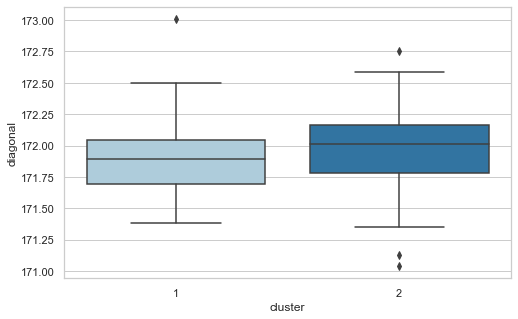

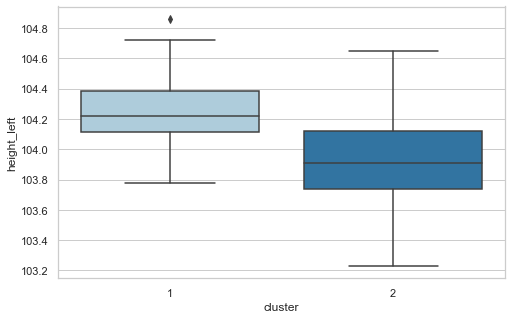

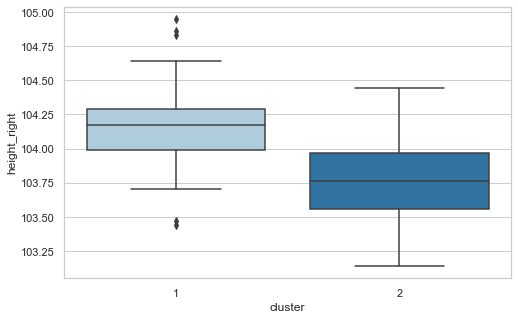

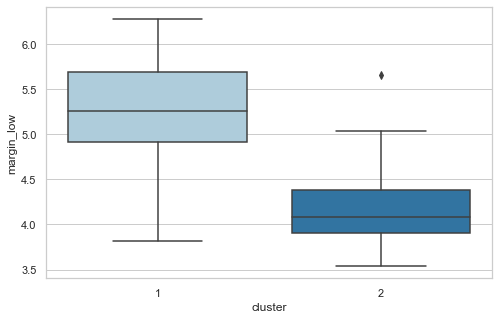

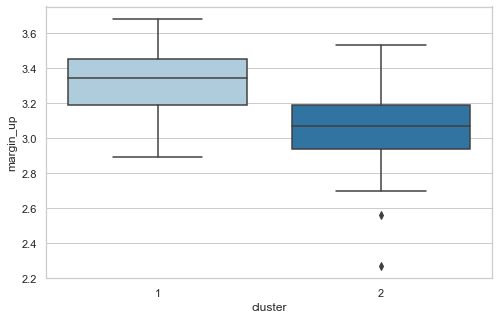

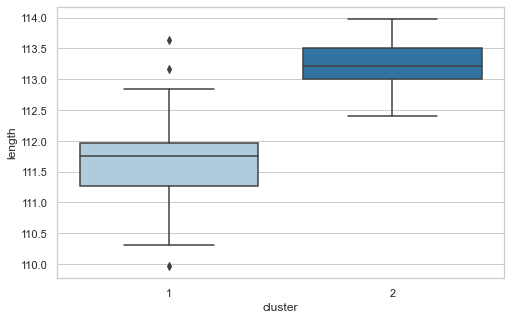

In [54]:
for i in cols: 
    _ = sns.boxplot(x='cluster', y=i, data=data)
    _ = plt.show()

In [55]:
cols_0 = data[['margin_low', 'length']]
cols_1 = data[['diagonal', 'height_right', 'margin_up']]

for i in cols:
    true = data.loc[data['cluster'] == 1][i]
    false = data.loc[data['cluster'] == 2][i]
    print(i.capitalize())
    if i in cols_0:
        print('Test de Mann-Whitney : ', sp.stats.mannwhitneyu(true, false))
    elif i in cols_1:
        print('Test de Bartlett :', sp.stats.bartlett(true,false))
        print('Test de Student :', sp.stats.ttest_ind(true,false, equal_var=True))
    else:
        print('Test de Bartlett :', sp.stats.bartlett(true,false))
        print('Test de Welsch :', sp.stats.ttest_ind(true,false, equal_var=False))

Diagonal
Test de Bartlett : BartlettResult(statistic=0.3206957103806736, pvalue=0.5711898481950044)
Test de Student : Ttest_indResult(statistic=-1.6884824741742679, pvalue=0.09317397341329761)
Height_left
Test de Bartlett : BartlettResult(statistic=5.184785738256288, pvalue=0.02278548163154469)
Test de Welsch : Ttest_indResult(statistic=7.908329193946792, pvalue=3.3910152999312346e-13)
Height_right
Test de Bartlett : BartlettResult(statistic=0.000714941140380228, pvalue=0.9786683986376231)
Test de Student : Ttest_indResult(statistic=9.660224307659364, pvalue=7.784663752107234e-18)
Margin_low
Test de Mann-Whitney :  MannwhitneyuResult(statistic=411.5, pvalue=5.441359874851291e-23)
Margin_up
Test de Bartlett : BartlettResult(statistic=0.1934828538491552, pvalue=0.6600335399794182)
Test de Student : Ttest_indResult(statistic=9.37667720595948, pvalue=4.57951873975617e-17)
Length
Test de Mann-Whitney :  MannwhitneyuResult(statistic=183.0, pvalue=3.300956216053636e-26)


In [56]:
for i in cols:
    print(i.capitalize())
    X = data['cluster'] # qualitative
    Y = data[i] # quantitative
    print('eta-squared :', eta_squared(X,Y))

Diagonal
eta-squared : 0.01668689978430001
Height_left
eta-squared : 0.25507907227898124
Height_right
eta-squared : 0.3571098934633154
Margin_low
eta-squared : 0.5928506899658359
Margin_up
eta-squared : 0.34355018135435744
Length
eta-squared : 0.699025418819586


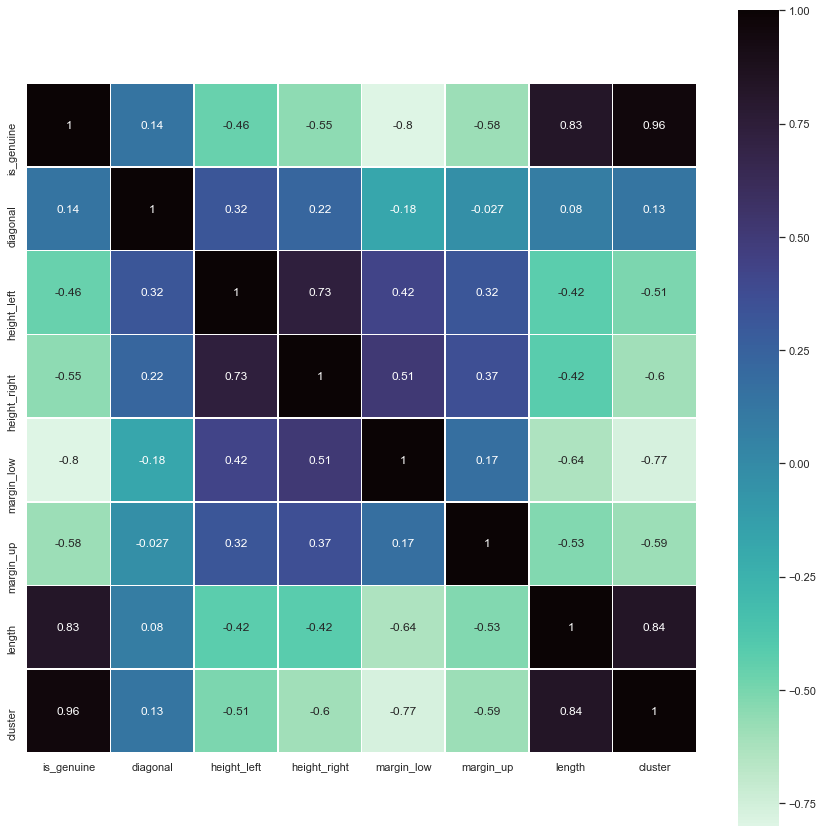

In [58]:
corrMatrix = data.corr()
plt.figure(figsize=(15,15))
_ = sns.heatmap(corrMatrix, square=True, annot=True, linewidths=.5, cmap='mako_r')
_ = plt.show()

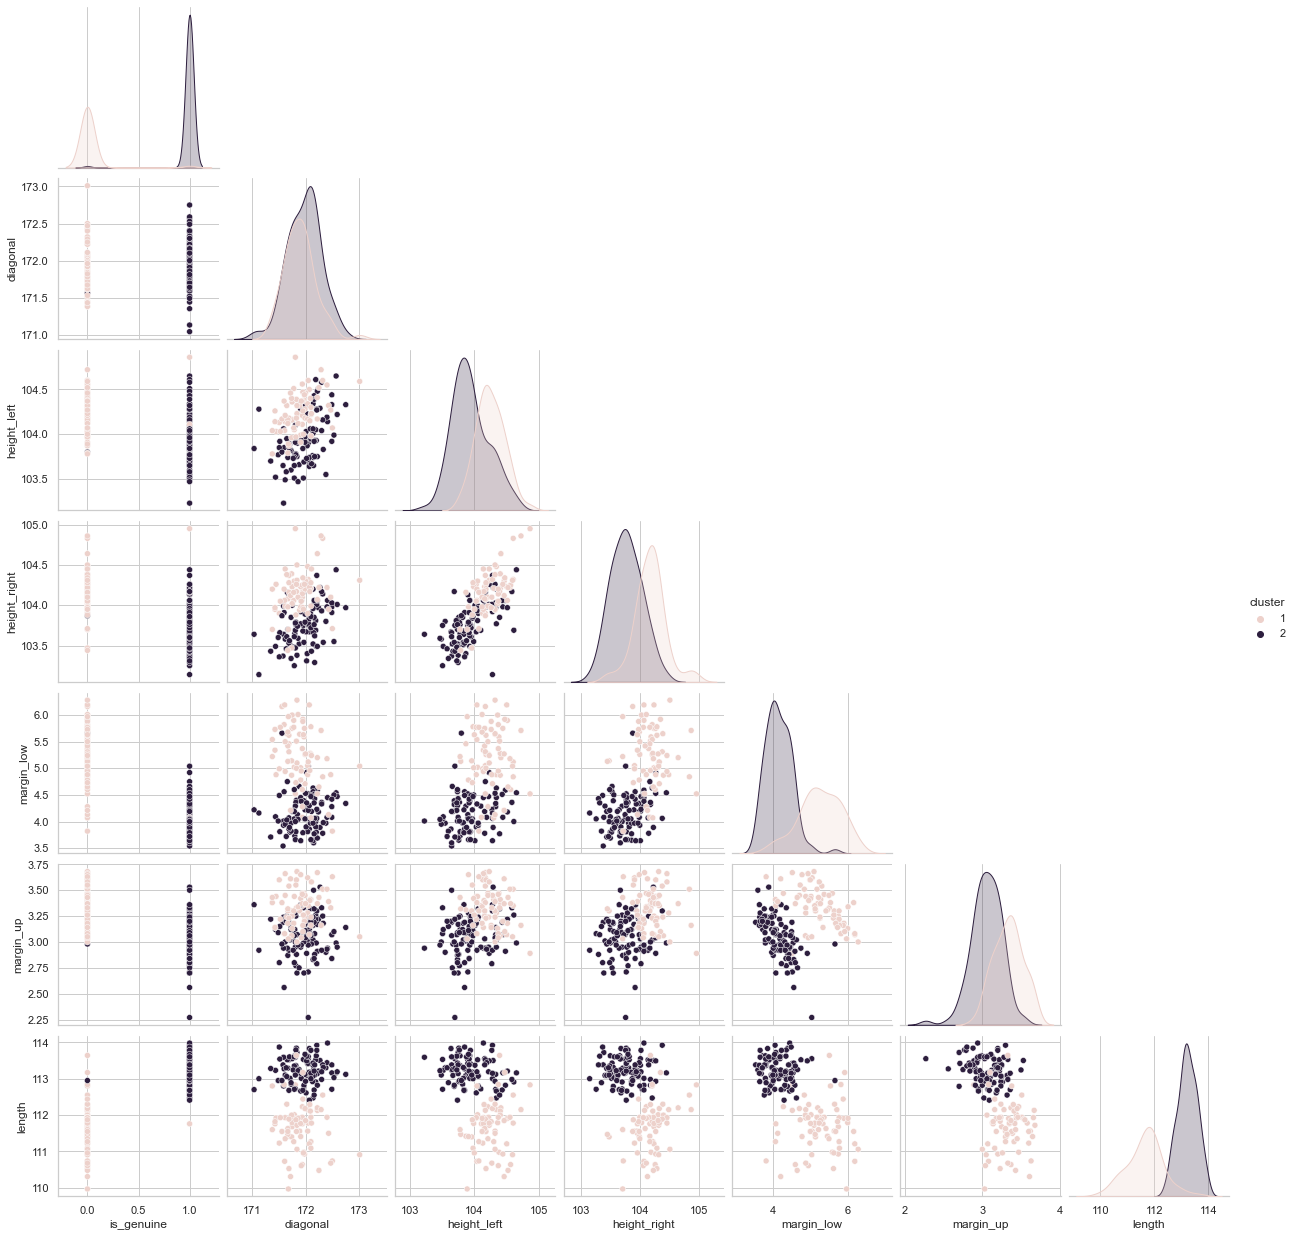

In [59]:
_ = sns.pairplot(data, hue='cluster', corner=True)
_ = plt.show()

## Kmeans

In [60]:
X = data.values

km = KMeans(n_clusters=2)
km.fit(X)
clustersk = km.labels_

In [61]:
data_clusterk = pd.DataFrame({'clusters_kmeans' : clustersk})
data = data.join(data_clusterk)
illustrative_var = data['clusters_kmeans']

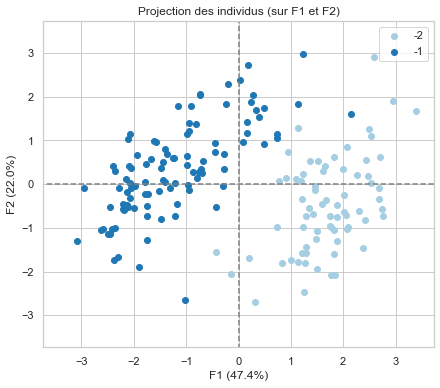

In [62]:
display_factorial_planes(coord, p, acp, [(0,1)], illustrative_var=~illustrative_var)


In [63]:
description = data.groupby('clusters_kmeans').describe().transpose()
print(description)

clusters_kmeans              0           1
diagonal     count  99.000000   71.000000 
             mean   171.976465  171.890563
             std    0.309527    0.295354  
             min    171.040000  171.380000
             25%    171.790000  171.685000
             50%    172.010000  171.890000
             75%    172.165000  172.045000
             max    172.750000  173.010000
height_left  count  99.000000   71.000000 
             mean   103.949899  104.228732
             std    0.297323    0.212084  
             min    103.230000  103.780000
             25%    103.740000  104.090000
             50%    103.910000  104.210000
             75%    104.150000  104.375000
             max    104.860000  104.720000
height_right count  99.000000   71.000000 
             mean   103.772020  104.145775
             std    0.291295    0.251343  
             min    103.140000  103.440000
             25%    103.555000  103.985000
             50%    103.760000  104.170000
           

In [64]:
cols_0 = data[['margin_low', 'length']]
cols_1 = data[['diagonal', 'height_right', 'margin_up']]

for i in cols:
    genuine = data.loc[data['is_genuine'] == True][i]
    clusterk = data.loc[data['clusters_kmeans'] == 0][i]
    print(i.capitalize())
    if i in cols_0:
        print('Test de Mann-Whitney : ', sp.stats.mannwhitneyu(genuine, clusterk))
    elif i in cols_1:
        print('Test de Bartlett :', sp.stats.bartlett(genuine,clusterk))
        print('Test de Student :', sp.stats.ttest_ind(genuine,clusterk, equal_var=True))
    else:
        print('Test de Bartlett :', sp.stats.bartlett(genuine,clusterk))
        print('Test de Welsch :', sp.stats.ttest_ind(genuine,clusterk, equal_var=False))

Diagonal
Test de Bartlett : BartlettResult(statistic=0.0024560019721142604, pvalue=0.9604745634939035)
Test de Student : Ttest_indResult(statistic=-0.00833018874896814, pvalue=0.9933619774649923)
Height_left
Test de Bartlett : BartlettResult(statistic=0.0012798180126682305, pvalue=0.9714621308565733)
Test de Welsch : Ttest_indResult(statistic=0.038048353991925105, pvalue=0.9696876650912428)
Height_right
Test de Bartlett : BartlettResult(statistic=0.0014187690787053776, pvalue=0.9699535453432222)
Test de Student : Ttest_indResult(statistic=0.09376365425016264, pvalue=0.9253921973097893)
Margin_low
Test de Mann-Whitney :  MannwhitneyuResult(statistic=4949.0, pvalue=0.49950883738688523)
Margin_up
Test de Bartlett : BartlettResult(statistic=0.003977817174502813, pvalue=0.9497108120242828)
Test de Student : Ttest_indResult(statistic=0.10645073598588996, pvalue=0.9153330620499752)
Length
Test de Mann-Whitney :  MannwhitneyuResult(statistic=4900.5, pvalue=0.451984273494459)


In [65]:
cols_0 = data[['margin_low', 'length']]
cols_1 = data[['diagonal', 'height_right', 'margin_up']]

for i in cols:
    genuine = data.loc[data['is_genuine'] == False][i]
    clusterk = data.loc[data['clusters_kmeans'] == 1][i]
    print(i.capitalize())
    if i in cols_0:
        print('Test de Mann-Whitney : ', sp.stats.mannwhitneyu(genuine, clusterk))
    elif i in cols_1:
        print('Test de Bartlett :', sp.stats.bartlett(genuine,clusterk))
        print('Test de Student :', sp.stats.ttest_ind(genuine,clusterk, equal_var=True))
    else:
        print('Test de Bartlett :', sp.stats.bartlett(genuine,clusterk))
        print('Test de Welsch :', sp.stats.ttest_ind(genuine,clusterk, equal_var=False))

Diagonal
Test de Bartlett : BartlettResult(statistic=0.003372734900236268, pvalue=0.9536886871198211)
Test de Student : Ttest_indResult(statistic=-0.014146989293169944, pvalue=0.9887329973245257)
Height_left
Test de Bartlett : BartlettResult(statistic=0.0016692764206281702, pvalue=0.9674100737199126)
Test de Welsch : Ttest_indResult(statistic=0.047364485381957144, pvalue=0.9622907432576605)
Height_right
Test de Bartlett : BartlettResult(statistic=0.0035484527276117782, pvalue=0.9524989960551565)
Test de Student : Ttest_indResult(statistic=-0.004783163148524644, pvalue=0.996190460424989)
Margin_low
Test de Mann-Whitney :  MannwhitneyuResult(statistic=2452.0, pvalue=0.4466879748077497)
Margin_up
Test de Bartlett : BartlettResult(statistic=0.003522349558862779, pvalue=0.9526738264694736)
Test de Student : Ttest_indResult(statistic=-0.006994896553009098, pvalue=0.9944289546709285)
Length
Test de Mann-Whitney :  MannwhitneyuResult(statistic=2484.5, pvalue=0.5)


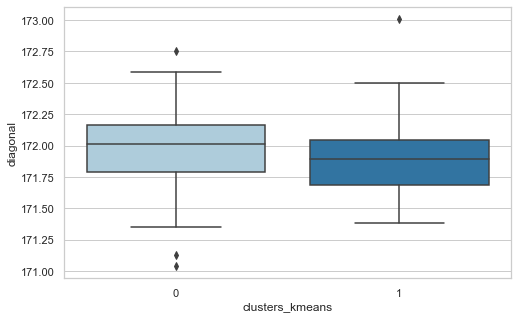

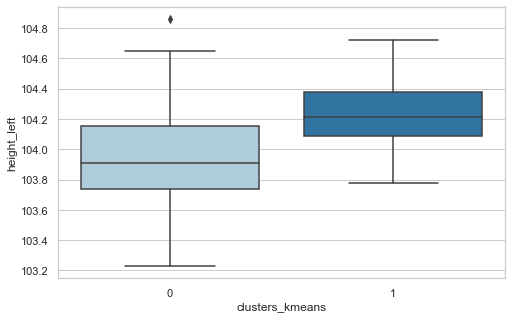

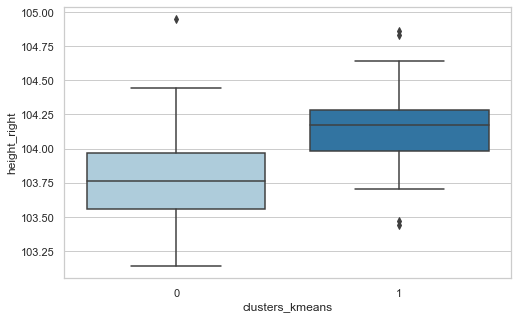

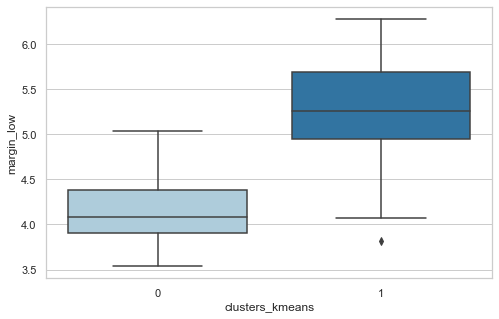

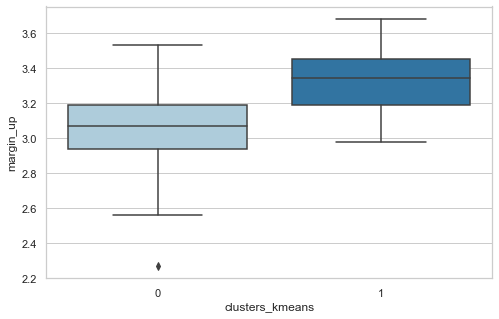

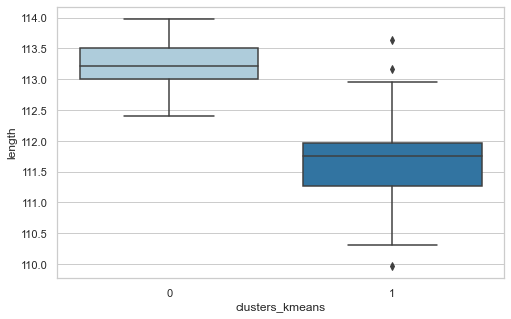

In [66]:
for i in cols: 
    _ = sns.boxplot(x='clusters_kmeans', y=i, data=data)
    _ = plt.show()

In [67]:
for i in cols:
    print(i.capitalize())
    X = data['clusters_kmeans'] # qualitative
    Y = data[i] # quantitative
    print('eta-squared :', eta_squared(X,Y))

Diagonal
eta-squared : 0.019309533895825372
Height_left
eta-squared : 0.21393176139161454
Height_right
eta-squared : 0.3119798433133232
Margin_low
eta-squared : 0.6231396905742382
Margin_up
eta-squared : 0.34891073616002233
Length
eta-squared : 0.6964312029598763


In [68]:
cols_0 = data[['margin_low', 'length']]
cols_1 = data[['diagonal', 'height_right', 'height_left', 'margin_up']]

for i in cols:
    true = data.loc[data['clusters_kmeans'] == 0][i]
    false = data.loc[data['clusters_kmeans'] == 1][i]
    print(i.capitalize())
    if i in cols_0:
        print('Test de Mann-Whitney : ', sp.stats.mannwhitneyu(true, false))
    elif i in cols_1:
        print('Test de Bartlett :', sp.stats.bartlett(true,false))
        print('Test de Student :', sp.stats.ttest_ind(true,false, equal_var=True))
    else:
        print('Test de Bartlett :', sp.stats.bartlett(true,false))
        print('Test de Welsch :', sp.stats.ttest_ind(true,false, equal_var=False))

Diagonal
Test de Bartlett : BartlettResult(statistic=0.17731389035949607, pvalue=0.6736918758904122)
Test de Student : Ttest_indResult(statistic=1.8187565046605412, pvalue=0.07072936562292413)
Height_left
Test de Bartlett : BartlettResult(statistic=8.773057405619403, pvalue=0.0030571257246553673)
Test de Student : Ttest_indResult(statistic=-6.761797334986516, pvalue=2.1539234482686791e-10)
Height_right
Test de Bartlett : BartlettResult(statistic=1.7317550813699039, pvalue=0.18818691256572284)
Test de Student : Ttest_indResult(statistic=-8.728052055194281, pvalue=2.4809007875578748e-15)
Margin_low
Test de Mann-Whitney :  MannwhitneyuResult(statistic=354.5, pvalue=8.996485951429831e-24)
Margin_up
Test de Bartlett : BartlettResult(statistic=0.3587022696058316, pvalue=0.5492278465111121)
Test de Student : Ttest_indResult(statistic=-9.48836844148114, pvalue=2.2826657785523355e-17)
Length
Test de Mann-Whitney :  MannwhitneyuResult(statistic=190.5, pvalue=4.244323910842022e-26)


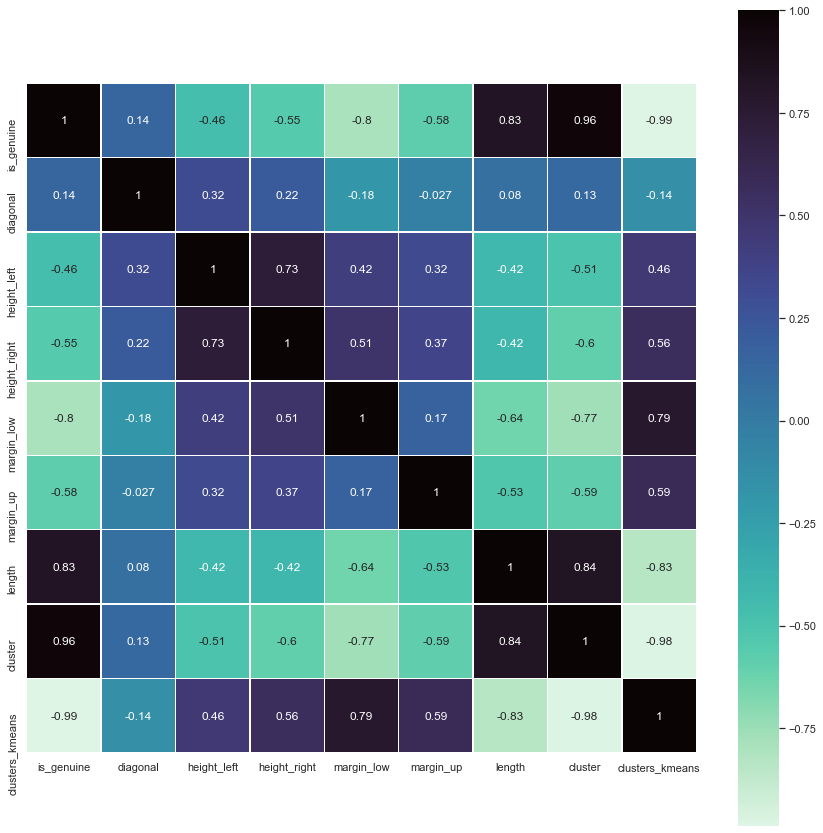

In [69]:
corrMatrix = data.corr()
plt.figure(figsize=(15,15))
_ = sns.heatmap(corrMatrix, square=True, annot=True, linewidths=.5, cmap='mako_r')
_ = plt.show()

C:\Users\maxim\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


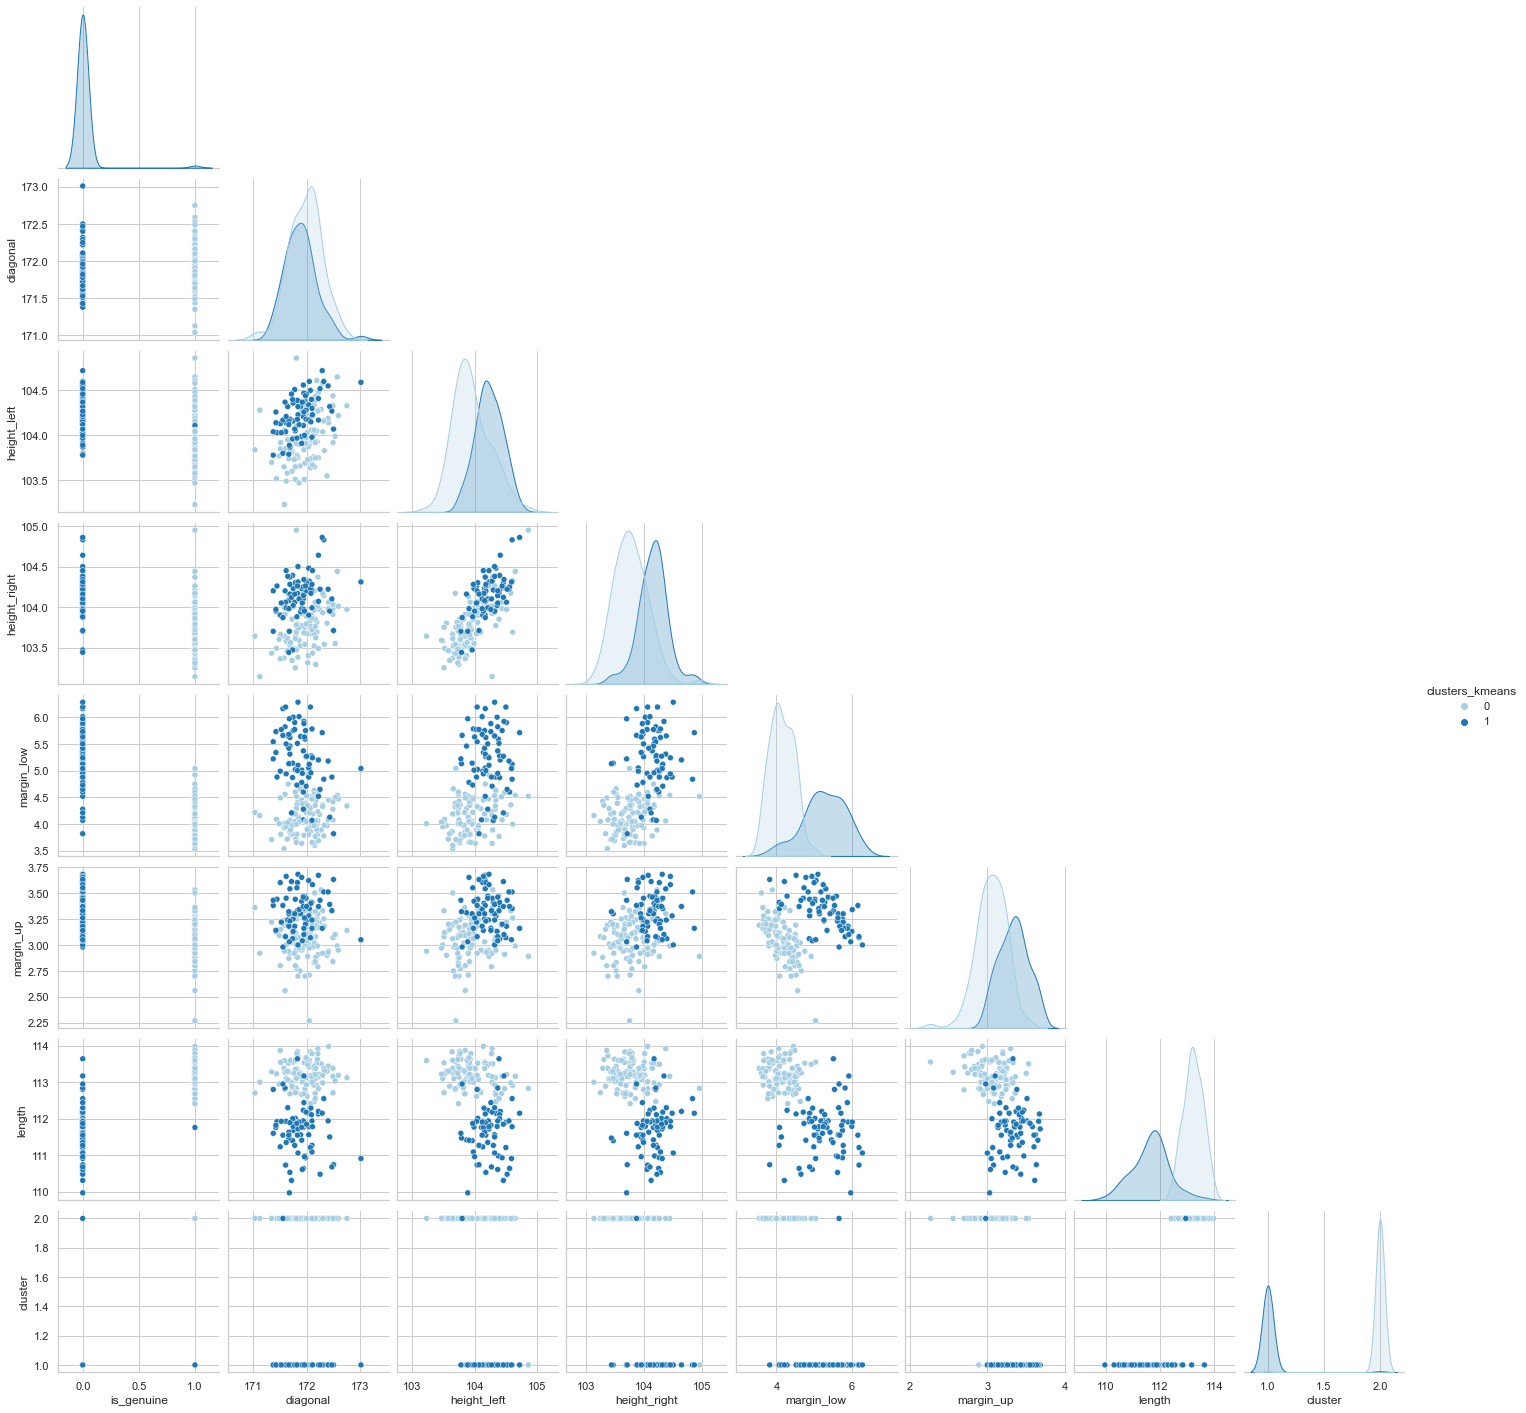

In [70]:
_ = sns.pairplot(data, hue='clusters_kmeans', corner=True)
_ = plt.show()

# Mission 3 : Modélisation
Modélisez les données à l'aide d'une régression logistique. Grâce à celle-ci, vous créerez un programme capable d'effectuer une prédiction sur un billet, c'est-à-dire de déterminer s'il s'agit d'un vrai ou d'un faux billet. Pour chaque billet, votre algorithme de classification devra donner la probabilité que le billet soit vrai. Si cette probabilité est supérieure ou égale à 0.5, le billet sera considéré comme vrai. Dans le cas contraire, il sera considéré comme faux.

In [71]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score

In [72]:
# Variables explicatives
X = data[['length', 'height_left', 'height_right', 'margin_low', 'margin_up', 'diagonal']]

# Variable à expliquer
y = data.is_genuine

In [73]:
# Partition aléatoire du jeu de données en 80% pour créer le modèle, 20% pour tester le modèle
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [74]:
# Régression logistique
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [75]:
# Stockage de prédictions
predictions = model.predict(X_test)
print(predictions)
print(y_test)

[ True False  True  True  True False  True  True False False False  True
 False  True  True  True  True False False False  True False  True False
 False  True False False False  True False  True  True  True]
99     True 
127    False
52     True 
9      True 
50     True 
137    False
61     True 
71     True 
106    False
126    False
110    False
39     True 
144    False
14     True 
81     True 
46     True 
57     True 
146    False
130    False
140    False
36     True 
152    False
33     True 
105    False
161    False
26     True 
120    False
101    False
167    False
25     True 
155    False
11     True 
0      True 
44     True 
Name: is_genuine, dtype: bool


In [76]:
# Evaluation du modèle
print(classification_report(y_test, predictions))

print(accuracy_score(y_test,predictions))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00        16
        True       1.00      1.00      1.00        18

    accuracy                           1.00        34
   macro avg       1.00      1.00      1.00        34
weighted avg       1.00      1.00      1.00        34

1.0


In [77]:
# Matrice de confusion
cm = confusion_matrix(y_test, predictions)

cm_df = pd.DataFrame(cm, 
            columns = ['Predicted Negative', 'Predicted Positive'],
            index = ['Actual Negative', 'Actual Positive'])
cm_df

,Predicted Negative,Predicted Positive
Actual Negative,16,0
Actual Positive,0,18


## Indicateurs

In [78]:
# Vrai positif (true positive)
TP = cm_df.iloc[1,1]

# Vrai négatif (true negative)
TN = cm_df.iloc[0,0]

# Faux négatif (false negative)
FN = cm_df.iloc[0,1]

# Faux positif (false positive)
FP = cm_df.iloc[1,0]

In [79]:
# Calcul de la sensibilité (taux de vrais positifs)
conf_sensitivity = (TP / float(TP + FN))

# Calcul de la spécificité (taux de vrais négatifs)
conf_specificity = (TN / float(TN + FP))

print("sensivity =",conf_sensitivity)
print("specificity =",conf_specificity)

sensivity = 1.0
specificity = 1.0


In [80]:
# Calcul de la précision (accuracy score)
conf_accuracy = (float (TP+TN) / float(TP + TN + FP + FN))
conf_accuracy

1.0

In [81]:
# Moyenne entre la sensibilité et la spécificité (balanced accuracy)
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(y_test, predictions, sample_weight=None, adjusted=False)

1.0

## Test du nouvel échantillon

In [82]:
new_sample = pd.read_csv('example_p6.csv')
new_sample.head()

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5


In [83]:
# Préparation des données
new_predict = new_sample[['length', 'height_left', 'height_right', 'margin_low', 'margin_up', 'diagonal']]

# Application du modèle
predict = model.predict(new_predict)

# Probabilités
model.predict_proba(new_predict)

array([[0.94538676, 0.05461324],
       [0.98636573, 0.01363427],
       [0.96798188, 0.03201812],
       [0.13997943, 0.86002057],
       [0.00461265, 0.99538735]])

In [84]:
# Ordre de lecture des probabilités
model.classes_

array([False,  True])

In [85]:
# Calcul des probas d'affectaion sur l'ech. à prédire
probas_ex = model.predict_proba(new_predict)

new_predict['Probas_faux'] = probas_ex[:,0]
new_predict['Probas_vrais'] = probas_ex[:,1]
new_predict

,length,height_left,height_right,margin_low,margin_up,diagonal,Probas_faux,Probas_vrais
0,111.42,104.01,103.54,5.21,3.30,171.76,0.945387,0.054613
1,112.09,104.17,104.13,6.00,3.31,171.87,0.986366,0.013634
2,111.57,104.58,104.29,4.99,3.39,172.00,0.967982,0.032018
3,113.20,104.55,104.34,4.44,3.03,172.49,0.139979,0.860021
4,113.33,103.63,103.56,3.77,3.16,171.65,0.004613,0.995387


In [86]:
# Ajout du resultat et création du df
prediction=pd.DataFrame({'id': new_sample.id,
                        'probalité_true' : new_predict.Probas_vrais,
                        'probalité_false' : new_predict.Probas_faux,
                        'prédiction' : predict})

prediction

,id,probalité_true,probalité_false,prédiction
0,A_1,0.054613,0.945387,False
1,A_2,0.013634,0.986366,False
2,A_3,0.032018,0.967982,False
3,A_4,0.860021,0.139979,True
4,A_5,0.995387,0.004613,True
